In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

In [2]:
# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

AutoGluon을 진행하고 나서, 해당 데이터에서는 LightGBM이 뛰어난 성능이라는 점을 파악함. <br><br>
AutoGluon에서 생각한 Feature Importance도 반영해서 컬럼 선택

#### 📊 각 모델별 Feature Importance 비교

| Feature 순위 | 로지스틱 회귀 (랜덤 언더 샘플링) | 로지스틱 회귀 (가중치) | 랜덤 포레스트 (랜덤 언더 샘플링) | XGBoost (랜덤 언더 샘플링) | LightGBM (랜덤 언더 샘플링) | LightGBM (가중치) | CatBoost (랜덤 언더 샘플링) | AutoGluon |
|------|------------------------------------------|------------------------------|--------------------------------------|--------------------------------|--------------------------------|----------------------|--------------------------------|------------------------------|
| 1    | VOC_STOP_CANCEL_MONTH1_YN              | VOC_STOP_CANCEL_MONTH1_YN    | TOTAL_USED_DAYS                     | VOC_TOTAL_MONTH1_YN           | TOTAL_USED_DAYS              | TOTAL_USED_DAYS      | AGMT_END_SEG                   | MONTHS_REMAINING       |
| 2    | CH_LAST_DAYS_BF_GRP                    | CH_LAST_DAYS_BF_GRP          | CH_HH_AVG_MONTH1                    | VOC_STOP_CANCEL_MONTH1_YN     | AGMT_END_SEG                 | AGMT_END_SEG         | CH_LAST_DAYS_BF_GRP            | TOTAL_USED_DAYS       |
| 3    | VOC_TOTAL_MONTH1_YN                     | VOC_TOTAL_MONTH1_YN          | CH_25_RATIO_1MONTH                   | CH_LAST_DAYS_BF_GRP           | CH_HH_AVG_MONTH1             | CH_HH_AVG_MONTH1     | VOC_STOP_CANCEL_MONTH1_YN      | CH_HH_AVG_MONTH1       |
| 4    | AGMT_END_SEG                            | TV_I_CNT                     | VOC_TOTAL_MONTH1_YN                  | BUNDLE_YN                     | CH_25_RATIO_1MONTH           | AGE_GRP10            | TOTAL_USED_DAYS                | INHOME_RATE           |
| 5    | TV_I_CNT                                | PAID_CHNL_CNT_GRP            | AGMT_END_SEG                         | AGMT_END_SEG                   | AGE_GRP10                    | CH_25_RATIO_1MONTH   | VOC_TOTAL_MONTH1_YN            | SCRB_PATH_NM_GRP       |
| 6    | PAID_CHNL_CNT_GRP                       | BUNDLE_YN                    | AGE_GRP10                            | AGMT_KIND_NM                   | CH_LAST_DAYS_BF_GRP          | CH_LAST_DAYS_BF_GRP  | CH_HH_AVG_MONTH1               | CH_LAST_DAYS_BF_GRP    |
| 7    | SVOD_SCRB_CNT_GRP                       | AGMT_END_SEG                 | VOC_STOP_CANCEL_MONTH1_YN            | TOTAL_USED_DAYS                | SCRB_PATH_NM_GRP             | SCRB_PATH_NM_GRP     | BUNDLE_YN                      | CH_25_RATIO_1MONTH     |
| 8    | BUNDLE_YN                               | SVOD_SCRB_CNT_GRP            | CH_LAST_DAYS_BF_GRP                  | DIGITAL_GIGA_YN                | TV_I_CNT                     | TV_I_CNT             | AGE_GRP10                      | CH_FAV_RNK1           |
| 9    | CH_FAV_RNK1                             | CH_FAV_RNK1                  | SCRB_PATH_NM_GRP                     | MEDIA_NM_GRP                   | INHOME_RATE                  | CH_FAV_RNK1          | INHOME_RATE                    | AGE_GRP10             |
| 10   | AGMT_KIND_NM                            | DIGITAL_GIGA_YN              | INHOME_RATE                          | INHOME_RATE                    | CH_FAV_RNK1                  | INHOME_RATE          | AGMT_KIND_NM                   | AGMT_KIND_NM          |
| 11   | DIGITAL_GIGA_YN                         | STB_RES_1M_YN                | CH_FAV_RNK1                          | CH_FAV_RNK1                     | AGMT_KIND_NM                 | AGMT_KIND_NM         | TV_I_CNT                        |                              |
| 12   | TOTAL_USED_DAYS                         | MEDIA_NM_GRP                 | TV_I_CNT                             | PAID_CHNL_CNT_GRP               | BUNDLE_YN                     | BUNDLE_YN            | CH_25_RATIO_1MONTH             |                              |
| 13   | INHOME_RATE                             | SCRB_PATH_NM_GRP             | AGMT_KIND_NM                         | CH_HH_AVG_MONTH1                | PROD_NM_GRP                   | PROD_NM_GRP          | CH_FAV_RNK1                    |                              |
| 14   | STB_RES_1M_YN                           | TOTAL_USED_DAYS              | PROD_NM_GRP                          | STB_RES_1M_YN                   | VOC_STOP_CANCEL_MONTH1_YN     | VOC_STOP_CANCEL_MONTH1_YN | SCRB_PATH_NM_GRP     |                              |
| 15   | SCRB_PATH_NM_GRP                        | INHOME_RATE                  | SVC_USE_DAYS_GRP                     | AGE_GRP10                       | MEDIA_NM_GRP                  | MEDIA_NM_GRP         | PROD_NM_GRP                    |                              |
| 16   | MEDIA_NM_GRP                            | CH_HH_AVG_MONTH1             | EMAIL_RECV_CLS_NM                    | PROD_NM_GRP                     | SVC_USE_DAYS_GRP              | SVC_USE_DAYS_GRP     | MEDIA_NM_GRP                   |                              |
| 17   | PROD_ONE_PLUS_YN                        | AGE_GRP10                    | SMS_SEND_CLS_NM                      | TV_I_CNT                        | KIDS_USE_PV_MONTH1            | KIDS_USE_PV_MONTH1   | SVC_USE_DAYS_GRP               |                              |
| 18   | SVC_USE_DAYS_GRP                        | PROD_NM_GRP                  | BUNDLE_YN                            | SVOD_SCRB_CNT_GRP               | VOC_TOTAL_MONTH1_YN           | VOC_TOTAL_MONTH1_YN  | PAID_CHNL_CNT_GRP              |                              |


선택했었던 컬럼들 + 파생변수들을 가지고 모델링을 진행<br><br>
채널 컬럼 같은 경우에는 기타 값이 너무 많아서, 그로 인해 기타에 해지 사람들이 많이 분포되어 있어서 중요하다고 뜬 것 같음. 그래서 채널은 무의미하다고 판단해서 X<br><br>

1차 선정 컬럼 + 01_11에서 만든 파생변수들

1. VOC_STOP_CANCEL_MONTH1_YN
2. BUNDLE_YN
3. CH_LAST_DAYS_BF_GRP
4. TOTAL_USED_DAYS
5. INHOME_RATE
6. TV_I_CNT
7. AGMT_END_SEG
8. VOC_TOTAL_MONTH1_YN
9. MEDIA_NM_GRP
10. CH_HH_AVG_MONTH1
11. AGMT_KIND_NM
12. PROD_NM_GRP
13. SCRB_PATH_NM_GRP
14. AGE_GRP10
15. STB_RES_1M_YN
16. SVC_USE_DAYS_GRP
17. PAID_CHNL_CNT_GRP

In [3]:
df_real = pd.read_csv("data/full_data/TPS_cancel_data_FeatureEngineering_end.csv")

In [4]:
# 해당 컬럼들 들고오기

df = df_real.filter(items=['sha2_hash','SVC_USE_DAYS_GRP','MEDIA_NM_GRP','PROD_NM_GRP','AGMT_KIND_NM','STB_RES_1M_YN',
                 'PAID_CHNL_CNT_GRP','SCRB_PATH_NM_GRP','INHOME_RATE','AGMT_END_SEG','TOTAL_USED_DAYS','BUNDLE_YN',
                 'TV_I_CNT','CH_LAST_DAYS_BF_GRP','VOC_TOTAL_MONTH1_YN','VOC_STOP_CANCEL_MONTH1_YN','AGE_GRP10',
                 'CH_HH_AVG_MONTH1','CONTENT_USE_YN','CH_LAST_DAYS_FE','AGMT_END_SEG_FE','KIDS_USE_YN','MONTHS_REMAINING',
                 'p_mt','churn'])

In [5]:
df.columns

Index(['sha2_hash', 'SVC_USE_DAYS_GRP', 'MEDIA_NM_GRP', 'PROD_NM_GRP',
       'AGMT_KIND_NM', 'STB_RES_1M_YN', 'PAID_CHNL_CNT_GRP',
       'SCRB_PATH_NM_GRP', 'INHOME_RATE', 'AGMT_END_SEG', 'TOTAL_USED_DAYS',
       'BUNDLE_YN', 'TV_I_CNT', 'CH_LAST_DAYS_BF_GRP', 'VOC_TOTAL_MONTH1_YN',
       'VOC_STOP_CANCEL_MONTH1_YN', 'AGE_GRP10', 'CH_HH_AVG_MONTH1',
       'CONTENT_USE_YN', 'CH_LAST_DAYS_FE', 'AGMT_END_SEG_FE', 'KIDS_USE_YN',
       'MONTHS_REMAINING', 'p_mt', 'churn'],
      dtype='object')

### 랜덤 언더 샘플링 데이터로 진행
1. 로지스틱
2. 랜덤 포레스트
3. XGB
4. LGBM
5. Cat

---

#### 1. LR 랜덤 언더 샘플링 데이터

In [6]:
# 2월 ~ 9월 train
# 6월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,7,8,9])]
val = df[df['p_mt'] == 6]
test = df[df['p_mt'] == 11]

In [7]:
train

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,Y,0건,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,N,4주일내,약정만료전후 3~12개월,N,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,N,4주일내,약정만료전후 3~12개월,N,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,N,4주일내,약정만료전후 3~12개월,N,10,5,N
5,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,0.00,약정만료전 6~9개월,886,Y,3.00,일주일내,Y,N,60대,2.93,N,4주일내,약정만료전후 3~12개월,N,8,7,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483370,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2215,N,1.00,일주일내,N,N,50대,2.42,N,4주일내,약정만료전후 12개월이상,N,-36,4,N
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2246,N,1.00,일주일내,N,N,50대,3.67,N,4주일내,약정만료전후 12개월이상,Y,-37,5,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2307,N,1.00,일주일내,N,N,50대,4.10,N,4주일내,약정만료전후 12개월이상,Y,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,N,4주일내,약정만료전후 12개월이상,N,-40,8,N


In [8]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [9]:
train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [10]:
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns = ['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [11]:
print("Before RU:")
print(y.value_counts())  # 원본 데이터 클래스 분포

print("\nAfter RU:")
print(pd.Series(y_resampled).value_counts())  # 증강 후 클래스 분포

Before RU:
churn
N    13599467
Y       92454
Name: count, dtype: int64

After RU:
churn
N    92454
Y    92454
Name: count, dtype: int64


In [12]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='churn')

resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

In [13]:
train = resampled_data

레이블 인코딩 진행

In [14]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)


{'PROD_NM_GRP': {'기타'}, 'INHOME_RATE': {'100.0'}}


In [15]:
val = val[val['PROD_NM_GRP'] != '기타'].reset_index(drop=True)
test = test[test['PROD_NM_GRP'] != '기타'].reset_index(drop=True)

val = val[val['INHOME_RATE'] != '100.0'].reset_index(drop=True)
test = test[test['INHOME_RATE'] != '100.0'].reset_index(drop=True)

In [17]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [18]:
display(train)
display(val)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,2,0,0,0,0,0,0,0,8,2926,0,2.00,3,0,0,5,0.01,0,1,0,0,-23,0
1,1,0,3,0,0,0,1,0,7,3631,0,2.00,1,0,0,5,0.00,0,0,2,0,10,0
2,2,0,3,5,0,0,0,2,1,1728,1,3.00,4,0,0,4,6.11,0,1,0,1,16,0
3,0,1,0,2,0,0,4,1,6,1825,0,2.00,4,1,0,3,0.91,1,1,2,0,8,0
4,0,1,4,5,0,0,1,3,1,1610,1,3.00,4,0,0,3,6.28,1,1,0,1,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184903,2,0,4,5,1,0,4,0,1,3712,1,2.00,4,0,0,5,1.90,0,1,0,0,30,1
184904,0,0,3,0,1,0,1,0,1,501,1,2.00,1,0,0,2,0.00,0,0,0,0,20,1
184905,4,1,4,0,1,0,9,0,1,11,1,2.00,4,1,0,4,3.49,1,1,0,0,36,1
184906,3,0,0,0,0,0,9,0,1,231,0,1.00,5,0,0,4,0.62,0,1,0,0,29,1


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,1,0,3,0,0,0,0,0,6,855,1,3.00,4,0,0,5,4.03,0,1,2,0,9,0
1,1,0,4,5,0,0,0,6,7,4249,1,2.00,4,0,0,4,18.08,0,1,2,0,12,0
2,2,0,0,5,0,0,4,1,1,2488,1,6.00,4,0,0,5,1.09,0,1,0,0,25,0
3,2,0,3,0,0,0,4,1,11,1836,0,3.00,4,0,0,5,1.32,0,1,2,0,-5,0
4,2,0,4,0,0,1,9,0,8,3826,1,4.00,4,0,0,4,1.27,0,1,0,0,-46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955096,2,0,0,5,0,0,9,0,8,3446,0,2.00,0,0,0,4,1.72,0,1,0,0,-43,0
1955097,2,0,3,0,0,0,1,1,8,2128,1,3.00,4,0,0,3,2.12,0,1,0,0,-34,0
1955098,0,0,3,2,0,0,4,0,8,3805,0,2.00,4,0,0,2,0.73,0,1,0,0,-104,0
1955099,2,1,0,5,0,0,0,2,1,1399,1,2.00,4,1,0,4,4.37,0,1,0,0,24,0


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,1,0,3,5,0,0,0,2,1,1008,1,3.00,4,0,0,5,6.23,0,1,0,0,33,0
1,1,0,4,5,0,0,0,7,6,4402,1,2.00,4,0,0,4,15.37,0,1,2,1,7,0
2,2,0,0,5,0,0,4,1,1,2641,1,6.00,4,0,0,5,1.47,0,1,0,1,20,0
3,2,0,3,0,0,0,4,1,13,1989,0,3.00,4,0,0,5,2.16,0,1,2,0,-10,0
4,2,0,4,0,0,1,9,0,8,3979,1,4.00,4,1,0,4,1.64,0,1,0,0,-51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945580,2,0,0,5,0,0,9,0,8,3599,0,2.00,1,0,0,4,0.00,0,0,0,0,-48,0
1945581,2,0,3,0,0,0,1,1,8,2281,1,3.00,4,0,0,3,1.81,0,1,0,0,-39,0
1945582,0,0,3,2,0,0,4,0,8,3958,0,2.00,4,0,0,2,1.69,0,1,0,0,-109,0
1945583,2,1,0,5,0,0,0,2,1,1552,1,2.00,4,0,0,4,3.39,0,1,0,0,19,0


In [19]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")


robust, minmax 끝


In [20]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Validation Accuracy: 0.77

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1941849
           1       0.02      0.67      0.04     13252

    accuracy                           0.77   1955101
   macro avg       0.51      0.72      0.45   1955101
weighted avg       0.99      0.77      0.87   1955101


Confusion Matrix (Validation):
[[1501629  440220]
 [   4340    8912]]


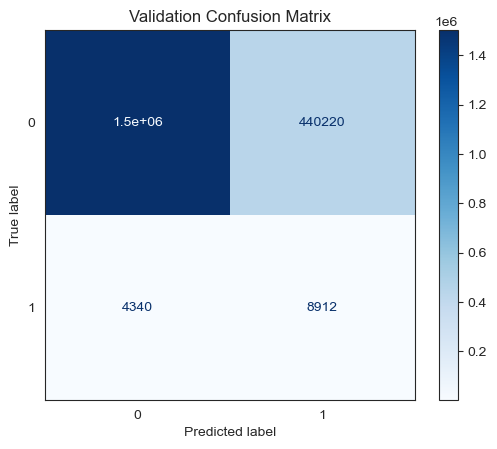

Validation AUC-ROC: 0.80


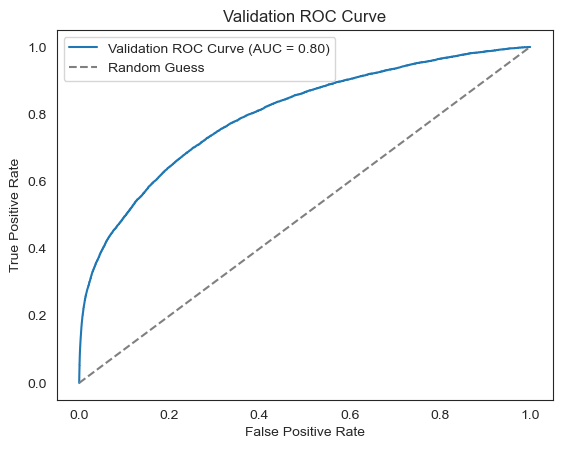

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

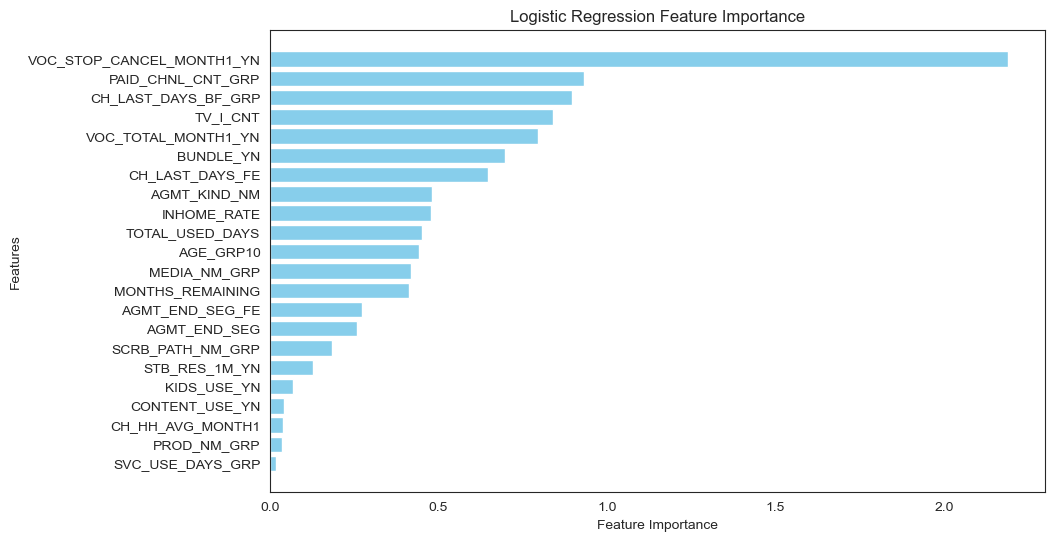

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. PAID_CHNL_CNT_GRP
3. CH_LAST_DAYS_BF_GRP
4. TV_I_CNT
5. VOC_TOTAL_MONTH1_YN
6. BUNDLE_YN
7. CH_LAST_DAYS_FE
8. AGMT_KIND_NM
9. INHOME_RATE
10. TOTAL_USED_DAYS
11. AGE_GRP10
12. MEDIA_NM_GRP
13. MONTHS_REMAINING
14. AGMT_END_SEG_FE
15. AGMT_END_SEG
16. SCRB_PATH_NM_GRP
17. STB_RES_1M_YN
18. KIDS_USE_YN
19. CONTENT_USE_YN
20. CH_HH_AVG_MONTH1
21. PROD_NM_GRP
22. SVC_USE_DAYS_GRP


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance 추출 (절댓값 사용)
feature_importance = np.abs(model.coef_[0])

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

#### 2. 랜덤 포레스트 랜덤 언더 샘플링

In [26]:
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Validation Accuracy: 0.80

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1941849
           1       0.02      0.70      0.04     13252

    accuracy                           0.80   1955101
   macro avg       0.51      0.75      0.47   1955101
weighted avg       0.99      0.80      0.88   1955101


Confusion Matrix (Validation):
[[1548150  393699]
 [   3966    9286]]


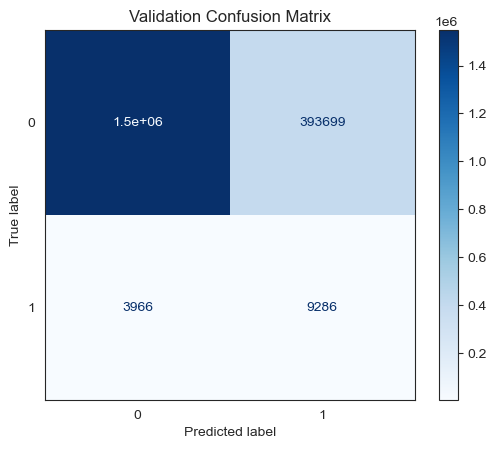

Validation AUC-ROC: 0.82


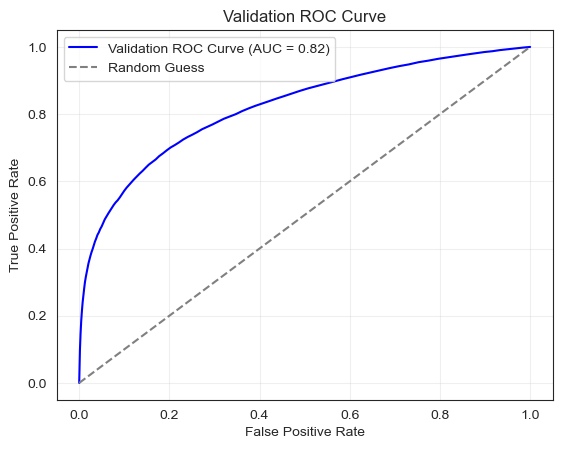

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = rf_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = rf_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

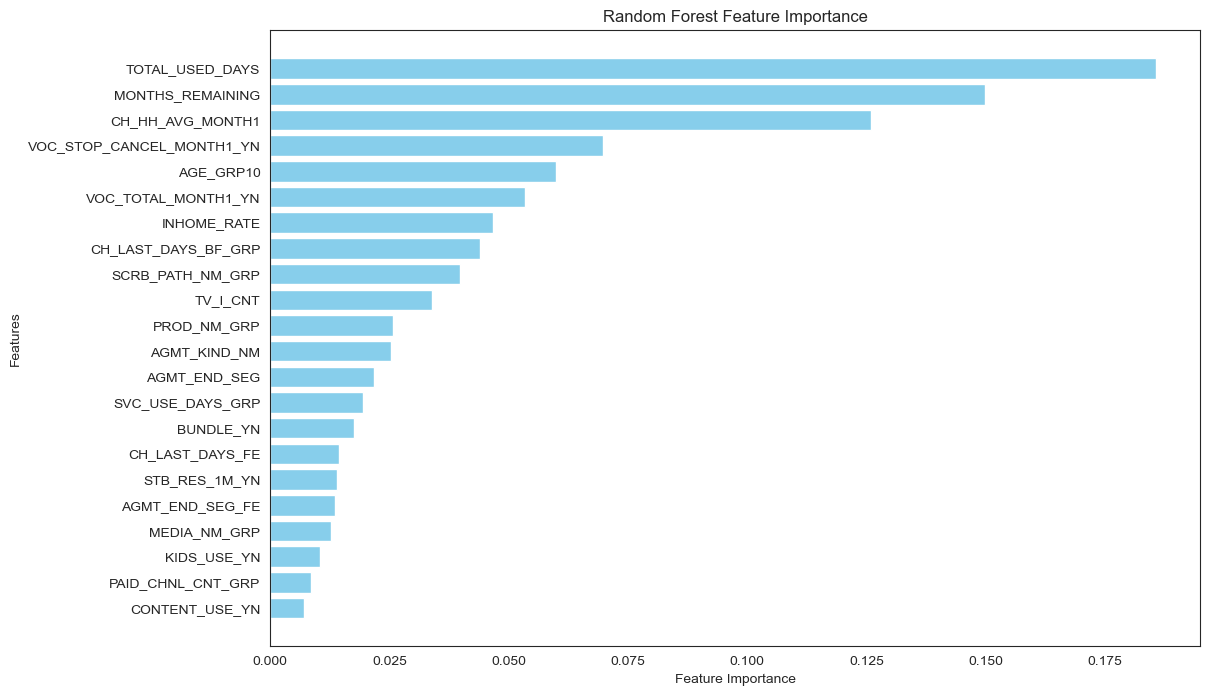

✅ Feature Importance
1. TOTAL_USED_DAYS
2. MONTHS_REMAINING
3. CH_HH_AVG_MONTH1
4. VOC_STOP_CANCEL_MONTH1_YN
5. AGE_GRP10
6. VOC_TOTAL_MONTH1_YN
7. INHOME_RATE
8. CH_LAST_DAYS_BF_GRP
9. SCRB_PATH_NM_GRP
10. TV_I_CNT
11. PROD_NM_GRP
12. AGMT_KIND_NM
13. AGMT_END_SEG
14. SVC_USE_DAYS_GRP
15. BUNDLE_YN
16. CH_LAST_DAYS_FE
17. STB_RES_1M_YN
18. AGMT_END_SEG_FE
19. MEDIA_NM_GRP
20. KIDS_USE_YN
21. PAID_CHNL_CNT_GRP
22. CONTENT_USE_YN


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

#### 3. XGB 랜덤 언더 샘플링

In [29]:
from xgboost import XGBClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941849
           1       0.02      0.71      0.05     13252

    accuracy                           0.81   1955101
   macro avg       0.51      0.76      0.47   1955101
weighted avg       0.99      0.81      0.89   1955101


Confusion Matrix (Validation):
[[1569870  371979]
 [   3852    9400]]


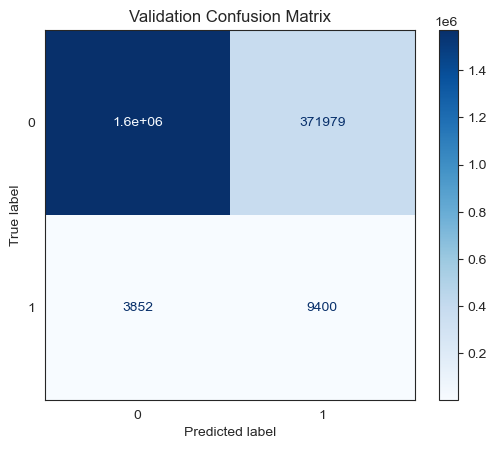

Validation AUC-ROC: 0.84


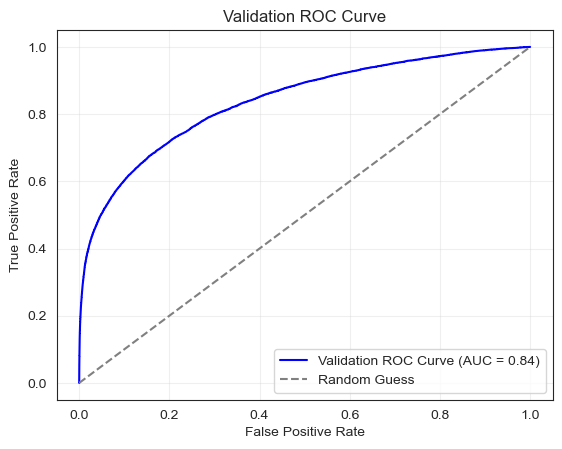

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


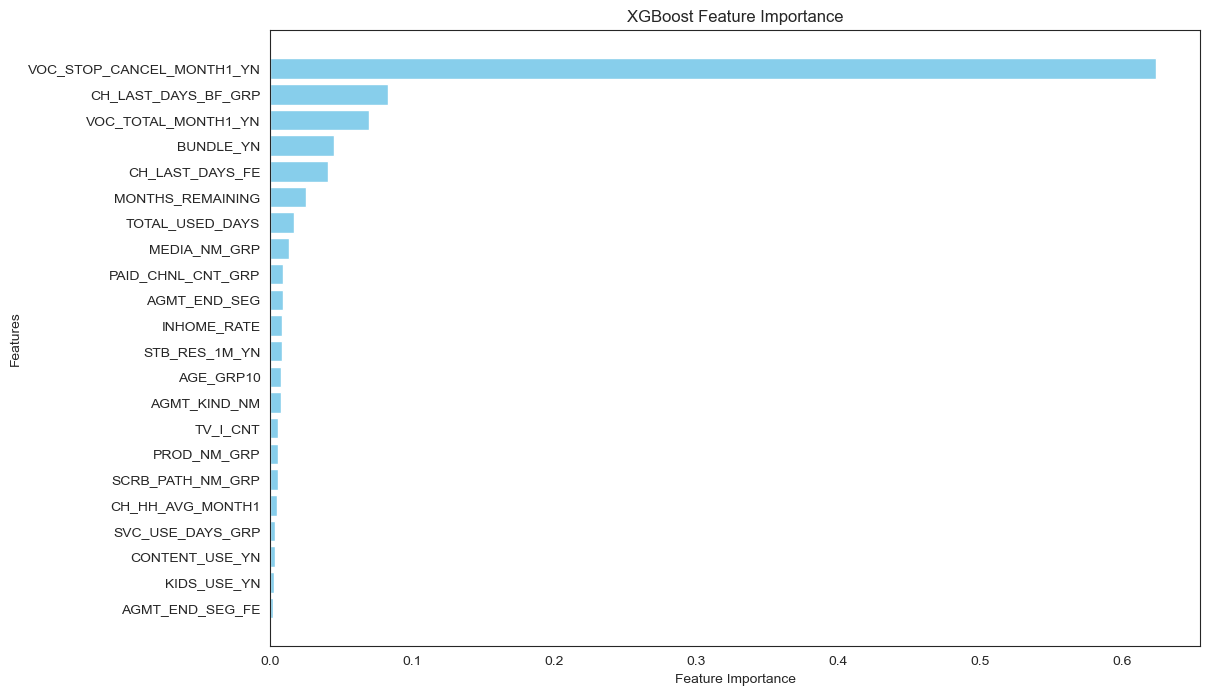

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. CH_LAST_DAYS_BF_GRP
3. VOC_TOTAL_MONTH1_YN
4. BUNDLE_YN
5. CH_LAST_DAYS_FE
6. MONTHS_REMAINING
7. TOTAL_USED_DAYS
8. MEDIA_NM_GRP
9. PAID_CHNL_CNT_GRP
10. AGMT_END_SEG
11. INHOME_RATE
12. STB_RES_1M_YN
13. AGE_GRP10
14. AGMT_KIND_NM
15. TV_I_CNT
16. PROD_NM_GRP
17. SCRB_PATH_NM_GRP
18. CH_HH_AVG_MONTH1
19. SVC_USE_DAYS_GRP
20. CONTENT_USE_YN
21. KIDS_USE_YN
22. AGMT_END_SEG_FE


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# XGBoost Feature Importance 추출
feature_importance = xgb_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 4. LGBM 랜덤 언더 샘플링

In [33]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941849
           1       0.02      0.71      0.05     13252

    accuracy                           0.81   1955101
   macro avg       0.51      0.76      0.47   1955101
weighted avg       0.99      0.81      0.89   1955101


Confusion Matrix (Validation):
[[1573493  368356]
 [   3842    9410]]


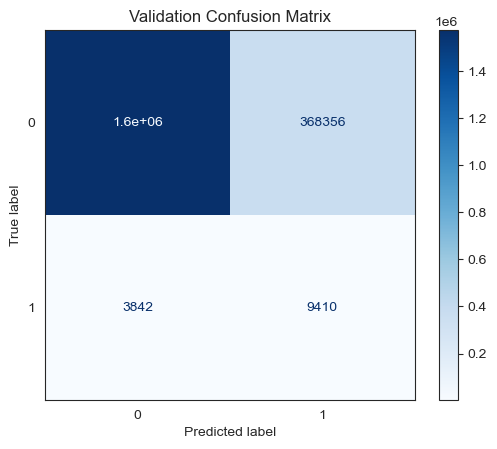

Validation AUC-ROC: 0.84


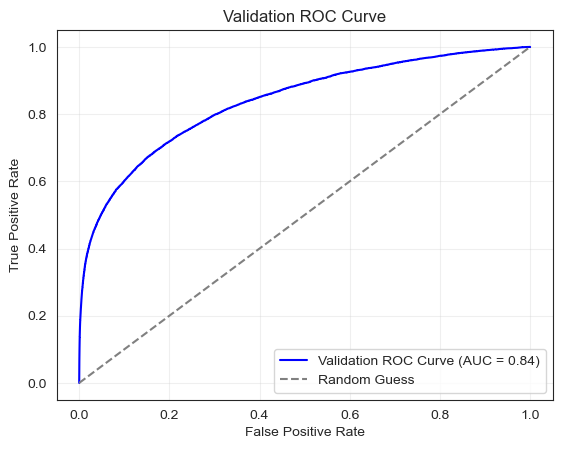

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

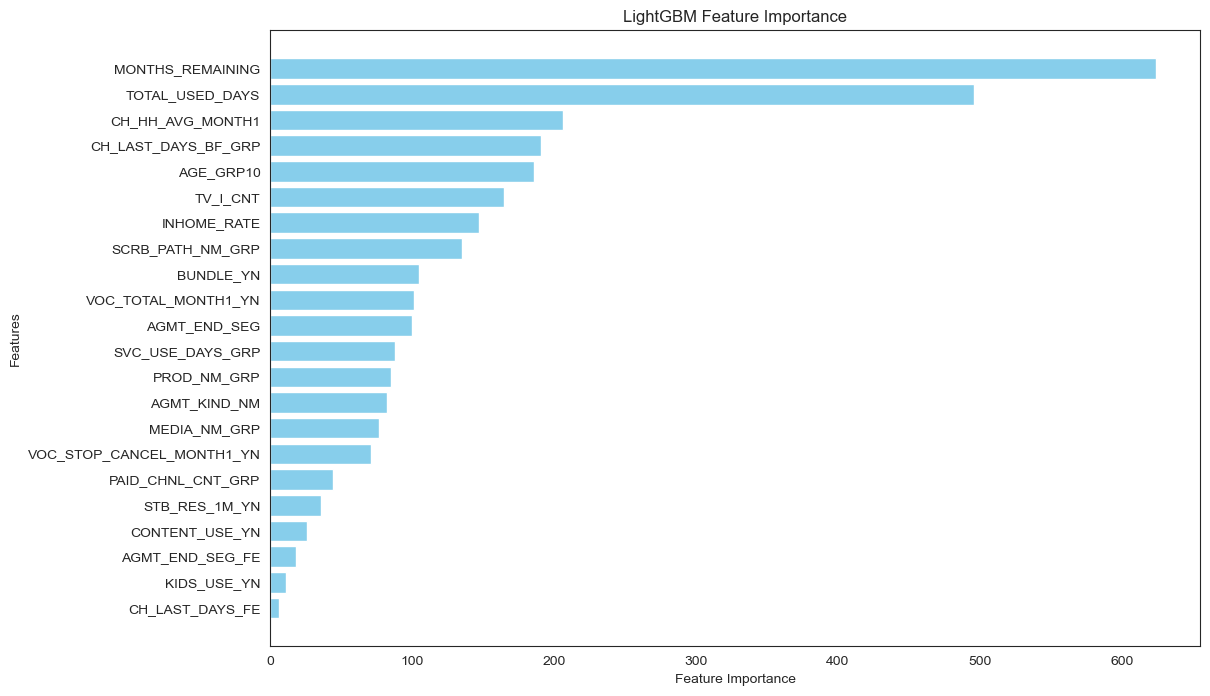

✅ Feature Importance
1. MONTHS_REMAINING
2. TOTAL_USED_DAYS
3. CH_HH_AVG_MONTH1
4. CH_LAST_DAYS_BF_GRP
5. AGE_GRP10
6. TV_I_CNT
7. INHOME_RATE
8. SCRB_PATH_NM_GRP
9. BUNDLE_YN
10. VOC_TOTAL_MONTH1_YN
11. AGMT_END_SEG
12. SVC_USE_DAYS_GRP
13. PROD_NM_GRP
14. AGMT_KIND_NM
15. MEDIA_NM_GRP
16. VOC_STOP_CANCEL_MONTH1_YN
17. PAID_CHNL_CNT_GRP
18. STB_RES_1M_YN
19. CONTENT_USE_YN
20. AGMT_END_SEG_FE
21. KIDS_USE_YN
22. CH_LAST_DAYS_FE


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 5. CatBoost 랜덤 언더 샘플링

In [36]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6801626	total: 184ms	remaining: 3m 3s
1:	learn: 0.6678135	total: 211ms	remaining: 1m 45s
2:	learn: 0.6561395	total: 238ms	remaining: 1m 19s
3:	learn: 0.6454908	total: 266ms	remaining: 1m 6s
4:	learn: 0.6357273	total: 292ms	remaining: 58s
5:	learn: 0.6269388	total: 321ms	remaining: 53.1s
6:	learn: 0.6185069	total: 357ms	remaining: 50.7s
7:	learn: 0.6108172	total: 386ms	remaining: 47.9s
8:	learn: 0.6038575	total: 412ms	remaining: 45.3s
9:	learn: 0.5972129	total: 442ms	remaining: 43.8s
10:	learn: 0.5914232	total: 465ms	remaining: 41.8s
11:	learn: 0.5858648	total: 491ms	remaining: 40.4s
12:	learn: 0.5807323	total: 515ms	remaining: 39.1s
13:	learn: 0.5765316	total: 539ms	remaining: 37.9s
14:	learn: 0.5724493	total: 559ms	remaining: 36.7s
15:	learn: 0.5680878	total: 581ms	remaining: 35.7s
16:	learn: 0.5639859	total: 607ms	remaining: 35.1s
17:	learn: 0.5605418	total: 630ms	remaining: 34.4s
18:	learn: 0.5571115	total: 652ms	remaining: 33.7s
19:	learn: 0.5542027	total: 677ms	remaini

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941849
           1       0.02      0.71      0.05     13252

    accuracy                           0.81   1955101
   macro avg       0.51      0.76      0.47   1955101
weighted avg       0.99      0.81      0.89   1955101


Confusion Matrix (Validation):
[[1568465  373384]
 [   3807    9445]]


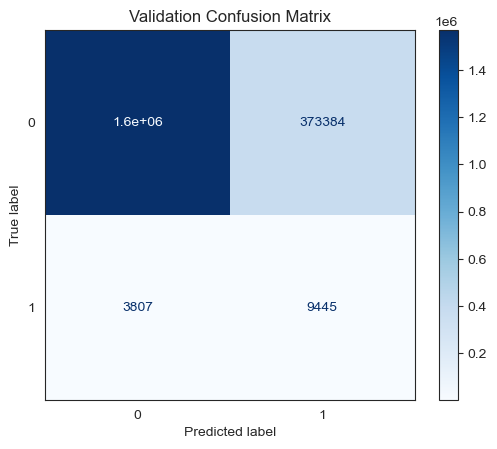

Validation AUC-ROC: 0.84


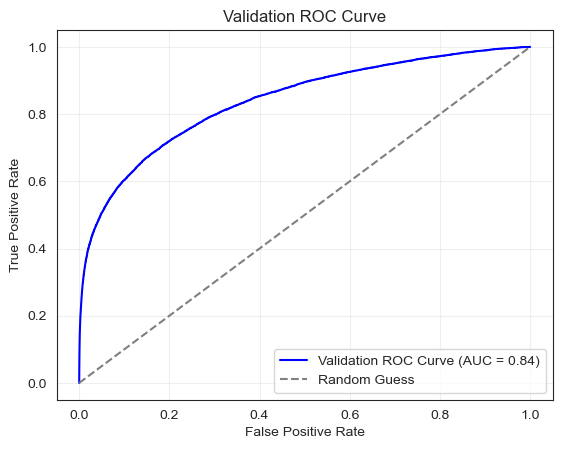

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

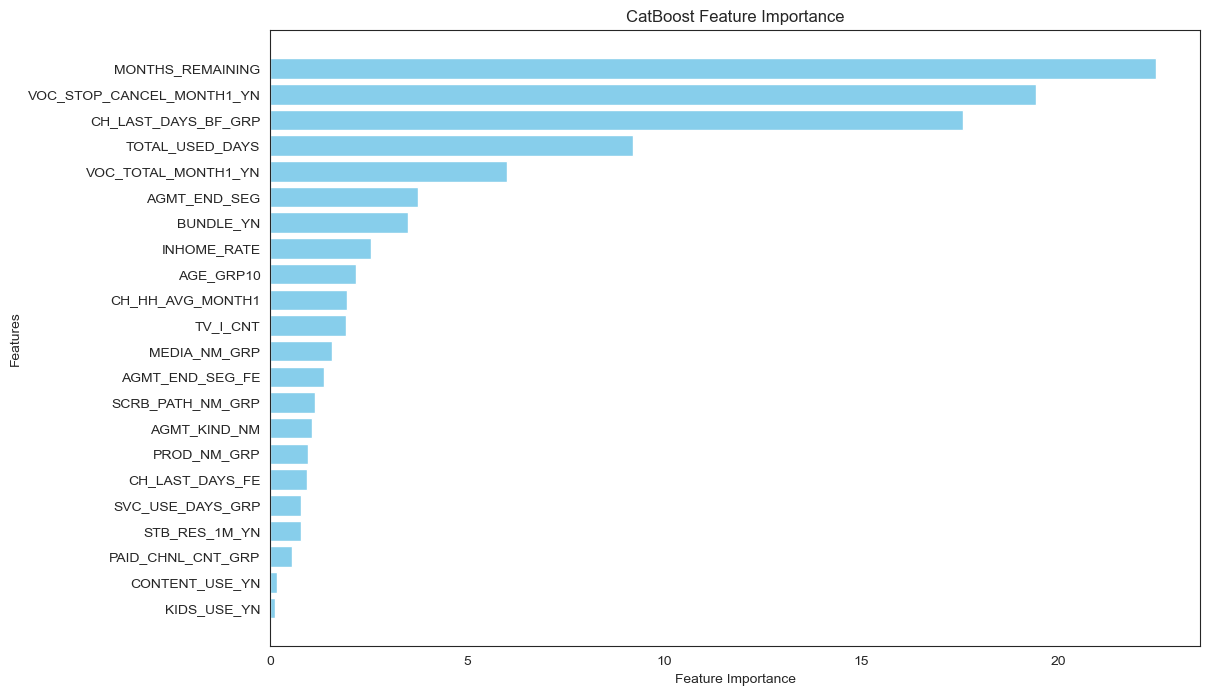

✅ Feature Importance
1. MONTHS_REMAINING
2. VOC_STOP_CANCEL_MONTH1_YN
3. CH_LAST_DAYS_BF_GRP
4. TOTAL_USED_DAYS
5. VOC_TOTAL_MONTH1_YN
6. AGMT_END_SEG
7. BUNDLE_YN
8. INHOME_RATE
9. AGE_GRP10
10. CH_HH_AVG_MONTH1
11. TV_I_CNT
12. MEDIA_NM_GRP
13. AGMT_END_SEG_FE
14. SCRB_PATH_NM_GRP
15. AGMT_KIND_NM
16. PROD_NM_GRP
17. CH_LAST_DAYS_FE
18. SVC_USE_DAYS_GRP
19. STB_RES_1M_YN
20. PAID_CHNL_CNT_GRP
21. CONTENT_USE_YN
22. KIDS_USE_YN


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

### 가중치로 진행
1. 로지스틱
2. LGBM

#### 1. LR 가중치

In [39]:
# 2월 ~ 9월 train
# 6월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,7,8,9])]
val = df[df['p_mt'] == 6]
test = df[df['p_mt'] == 11]

In [40]:
train

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,N,3개월내없음,약정만료전후 12개월이상,N,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,Y,0건,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,N,4주일내,약정만료전후 3~12개월,N,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,N,4주일내,약정만료전후 3~12개월,N,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,N,4주일내,약정만료전후 3~12개월,N,10,5,N
5,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,신규,N,0건,I/B,0.00,약정만료전 6~9개월,886,Y,3.00,일주일내,Y,N,60대,2.93,N,4주일내,약정만료전후 3~12개월,N,8,7,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483370,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2215,N,1.00,일주일내,N,N,50대,2.42,N,4주일내,약정만료전후 12개월이상,N,-36,4,N
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2246,N,1.00,일주일내,N,N,50대,3.67,N,4주일내,약정만료전후 12개월이상,Y,-37,5,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2307,N,1.00,일주일내,N,N,50대,4.10,N,4주일내,약정만료전후 12개월이상,Y,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,신규,N,0건,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,N,4주일내,약정만료전후 12개월이상,N,-40,8,N


In [41]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [42]:
train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [43]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [44]:
display(train)
display(val)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
0,0,0,4,0,0,0,0,1,1,733,1,3.00,1,0,0,5,0.00,0,0,0,0,13,0
1,1,0,4,0,1,0,0,0,7,764,1,3.00,4,1,0,5,6.72,0,1,2,0,12,0
2,1,0,4,0,0,0,0,1,7,794,1,3.00,2,0,0,5,9.86,0,1,2,0,11,0
3,1,0,4,0,0,0,0,1,7,825,1,3.00,3,0,0,5,5.95,0,1,2,0,10,0
5,1,0,4,0,0,0,0,0,6,886,1,3.00,4,1,0,5,2.93,0,1,2,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483370,2,0,1,0,0,0,9,1,8,2215,0,1.00,4,0,0,4,2.42,0,1,0,0,-36,0
21483371,2,0,1,0,0,0,9,1,8,2246,0,1.00,4,0,0,4,3.67,0,1,0,1,-37,0
21483373,2,0,1,0,0,0,9,1,8,2307,0,1.00,4,0,0,4,4.10,0,1,0,1,-39,0
21483374,2,0,1,0,0,0,9,1,8,2338,0,1.00,4,0,0,4,2.03,0,1,0,0,-40,0


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
4,1,0,4,0,0,0,0,0,6,855,1,3.00,4,0,0,5,4.03,0,1,2,0,9,0
15,1,0,5,5,0,0,0,7,7,4249,1,2.00,4,0,0,4,18.08,0,1,2,0,12,0
26,2,0,1,5,0,0,4,1,1,2488,1,6.00,4,0,0,5,1.09,0,1,0,0,25,0
37,2,0,4,0,0,0,4,1,11,1836,0,3.00,4,0,0,5,1.32,0,1,2,0,-5,0
48,2,0,5,0,0,1,9,0,8,3826,1,4.00,4,0,0,4,1.27,0,1,0,0,-46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483328,2,0,1,5,0,0,9,0,8,3446,0,2.00,0,0,0,4,1.72,0,1,0,0,-43,0
21483339,2,0,4,0,0,0,1,1,8,2128,1,3.00,4,0,0,3,2.12,0,1,0,0,-34,0
21483350,0,0,4,2,0,0,4,0,8,3805,0,2.00,4,0,0,2,0.73,0,1,0,0,-104,0
21483361,2,1,1,5,0,0,0,3,1,1399,1,2.00,4,1,0,4,4.37,0,1,0,0,24,0


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,CONTENT_USE_YN,CH_LAST_DAYS_FE,AGMT_END_SEG_FE,KIDS_USE_YN,MONTHS_REMAINING,churn
9,1,0,4,5,0,0,0,3,1,1008,1,3.00,4,0,0,5,6.23,0,1,0,0,33,0
20,1,0,5,5,0,0,0,8,6,4402,1,2.00,4,0,0,4,15.37,0,1,2,1,7,0
31,2,0,1,5,0,0,4,1,1,2641,1,6.00,4,0,0,5,1.47,0,1,0,1,20,0
42,2,0,4,0,0,0,4,1,13,1989,0,3.00,4,0,0,5,2.16,0,1,2,0,-10,0
53,2,0,5,0,0,1,9,0,8,3979,1,4.00,4,1,0,4,1.64,0,1,0,0,-51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483333,2,0,1,5,0,0,9,0,8,3599,0,2.00,1,0,0,4,0.00,0,0,0,0,-48,0
21483344,2,0,4,0,0,0,1,1,8,2281,1,3.00,4,0,0,3,1.81,0,1,0,0,-39,0
21483355,0,0,4,2,0,0,4,0,8,3958,0,2.00,4,0,0,2,1.69,0,1,0,0,-109,0
21483366,2,1,1,5,0,0,0,3,1,1552,1,2.00,4,0,0,4,3.39,0,1,0,0,19,0


In [45]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [46]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Validation Accuracy: 0.77

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1941863
           1       0.02      0.67      0.04     13252

    accuracy                           0.77   1955115
   macro avg       0.51      0.72      0.45   1955115
weighted avg       0.99      0.77      0.87   1955115


Confusion Matrix (Validation):
[[1501130  440733]
 [   4348    8904]]


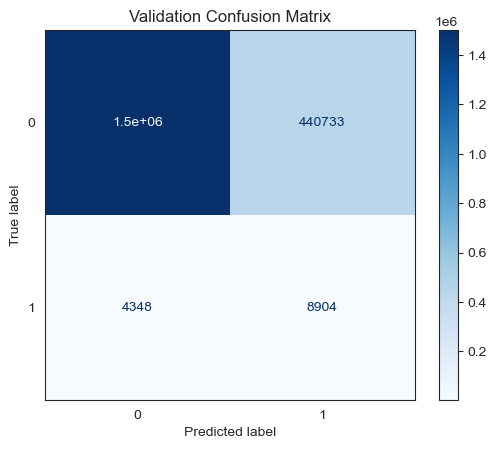

Validation AUC-ROC: 0.80


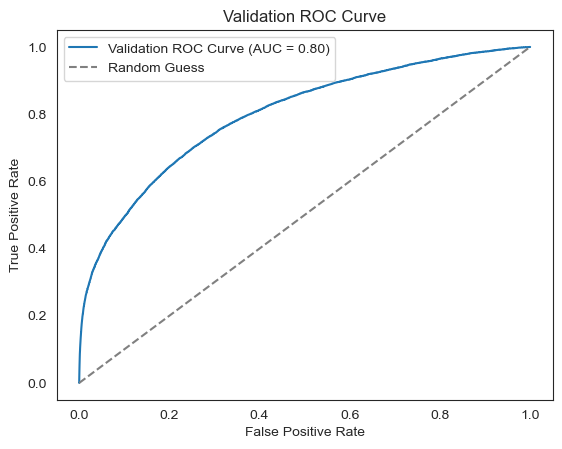

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()


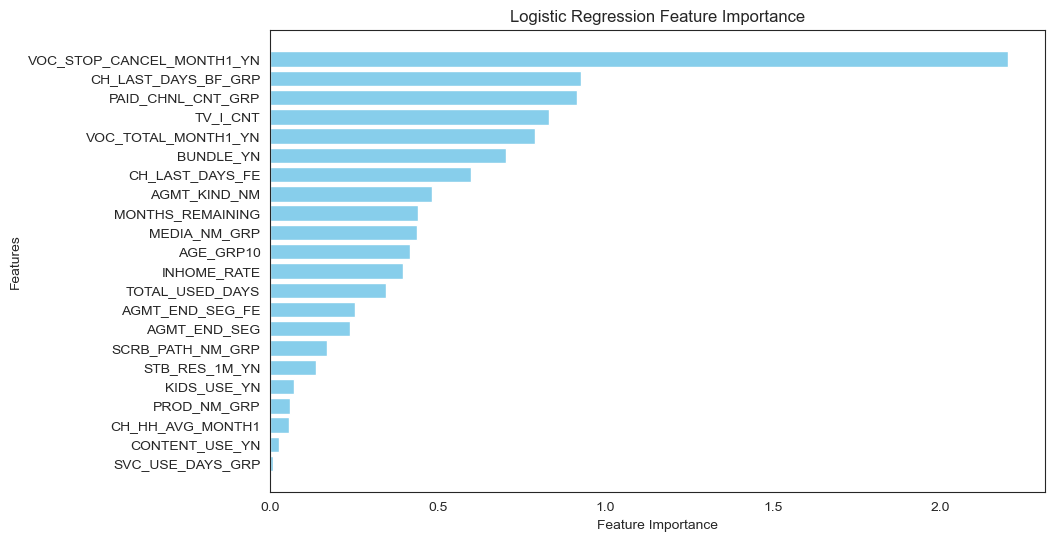

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. CH_LAST_DAYS_BF_GRP
3. PAID_CHNL_CNT_GRP
4. TV_I_CNT
5. VOC_TOTAL_MONTH1_YN
6. BUNDLE_YN
7. CH_LAST_DAYS_FE
8. AGMT_KIND_NM
9. MONTHS_REMAINING
10. MEDIA_NM_GRP
11. AGE_GRP10
12. INHOME_RATE
13. TOTAL_USED_DAYS
14. AGMT_END_SEG_FE
15. AGMT_END_SEG
16. SCRB_PATH_NM_GRP
17. STB_RES_1M_YN
18. KIDS_USE_YN
19. PROD_NM_GRP
20. CH_HH_AVG_MONTH1
21. CONTENT_USE_YN
22. SVC_USE_DAYS_GRP


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 2. LGBM 가중치

In [49]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 가중치 적용
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941863
           1       0.02      0.71      0.05     13252

    accuracy                           0.81   1955115
   macro avg       0.51      0.76      0.47   1955115
weighted avg       0.99      0.81      0.89   1955115


Confusion Matrix (Validation):
[[1572944  368919]
 [   3863    9389]]


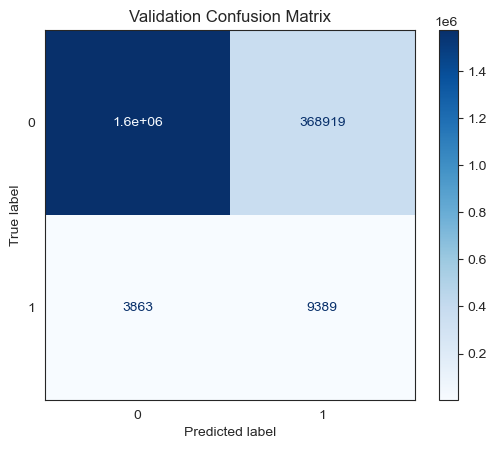

Validation AUC-ROC: 0.84


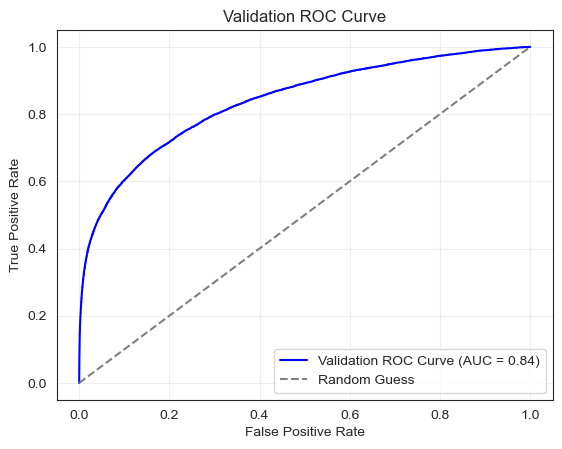

In [50]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

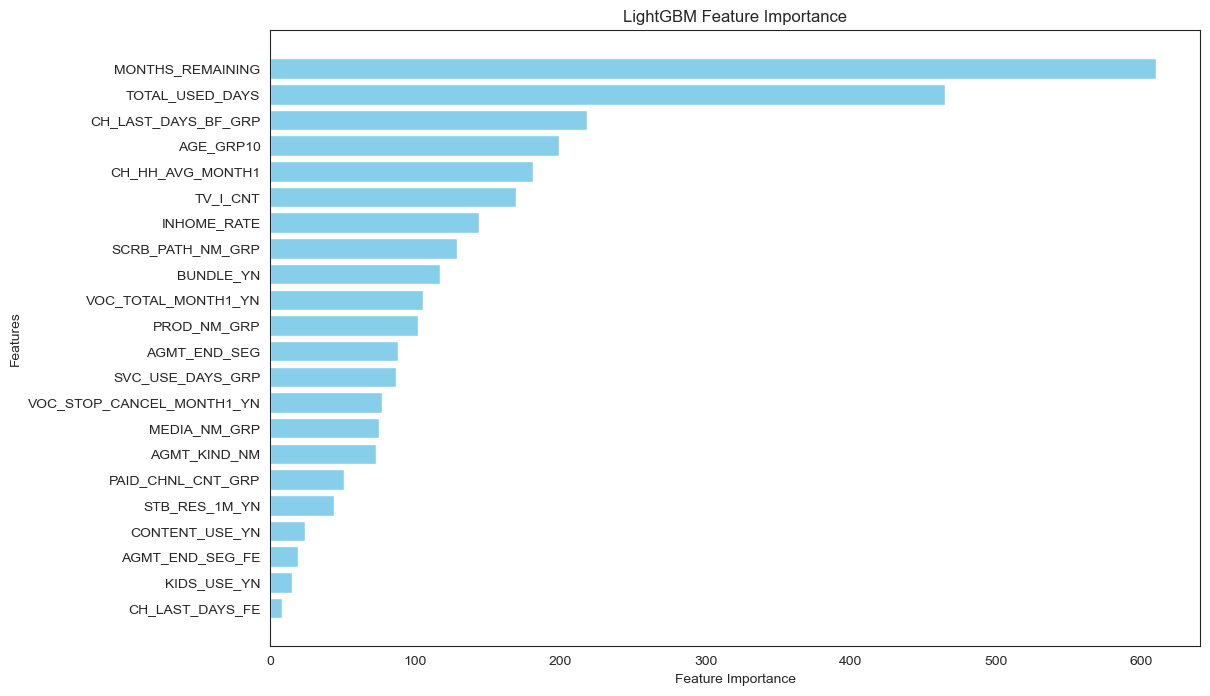

✅ Feature Importance
1. MONTHS_REMAINING
2. TOTAL_USED_DAYS
3. CH_LAST_DAYS_BF_GRP
4. AGE_GRP10
5. CH_HH_AVG_MONTH1
6. TV_I_CNT
7. INHOME_RATE
8. SCRB_PATH_NM_GRP
9. BUNDLE_YN
10. VOC_TOTAL_MONTH1_YN
11. PROD_NM_GRP
12. AGMT_END_SEG
13. SVC_USE_DAYS_GRP
14. VOC_STOP_CANCEL_MONTH1_YN
15. MEDIA_NM_GRP
16. AGMT_KIND_NM
17. PAID_CHNL_CNT_GRP
18. STB_RES_1M_YN
19. CONTENT_USE_YN
20. AGMT_END_SEG_FE
21. KIDS_USE_YN
22. CH_LAST_DAYS_FE


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 📌 팀 프로젝트 주제에 알맞은 모델 선택 기준

##### 1️. FN(False Negative) 감소  
- 실제 해지 고객(1)을 모델이 해지가 아니라고 예측한 경우(FN)
- **FN이 높을수록, 해지할 고객을 제대로 예측하지 못한 것**이므로 **최대한 줄여야 함**  

##### 2️. TP(True Positive) 증가  
- 실제 해지 고객(1)을 모델이 올바르게 해지라고 예측한 경우(TP) 
- **TP 값을 높여야 해지할 고객을 정확히 찾아낼 수 있음**

##### 3️. FP(False Positive) 최소화  
- 실제 해지가 아닌 고객(0)을 모델이 해지라고 예측한 경우(FP)
- FP는 단순한 경고로 끝날 수 있으므로 완전히 없애야 할 필요는 없지만, **가능한 줄이는 것이 좋음**


#### 📌 결론  
✅ **FN(실제 해지를 놓친 경우)를 줄이고, TP(정확한 해지 예측)를 최대한 높이는 모델이 가장 적합함**<BR>
✅ **FP(잘못된 해지 예측)는 어느 정도 감수할 수 있지만, 너무 많으면 고객 경험에 부정적인 영향을 줄 수 있음**<BR>
✅ **따라서, Recall(재현율)과 Precision(정밀도) 균형을 고려하여 최적의 모델을 선택해야 함**.

해당 모델 선정 기준으로 1차 선정된 Feature들로 모델을 진행한 결과, <br><br>

로지스틱 회귀 랜덤언더 FE < **로지스틱 회귀 랜덤언더** <br>
**랜덤포레스트 랜덤언더 FE** > 랜덤포레스트 랜덤언더 <br>
XGB 랜덤언더 FE < **XGB 랜덤언더** <br>
LGBM 랜덤언더 FE < **LGBM 랜덤언더** <br>
CAT 랜덤언더 FE < **CAT 랜덤언더** <br>
로지스틱 회귀 가중치 FE < **로지스틱 회귀 가중치** <br>
**LGBM 가중치 FE** > LGBM 가중치 ⭐ <br><br>
랜덤포레스트(랜덤 언더 샘플링)와 LightGBM(가중치)에서 좀 더 나은 성능을 보여줬음.<br><br>
특히, LGBM은 FN 값은 감소, TP 값은 증가, FP 값은 감소하였음.

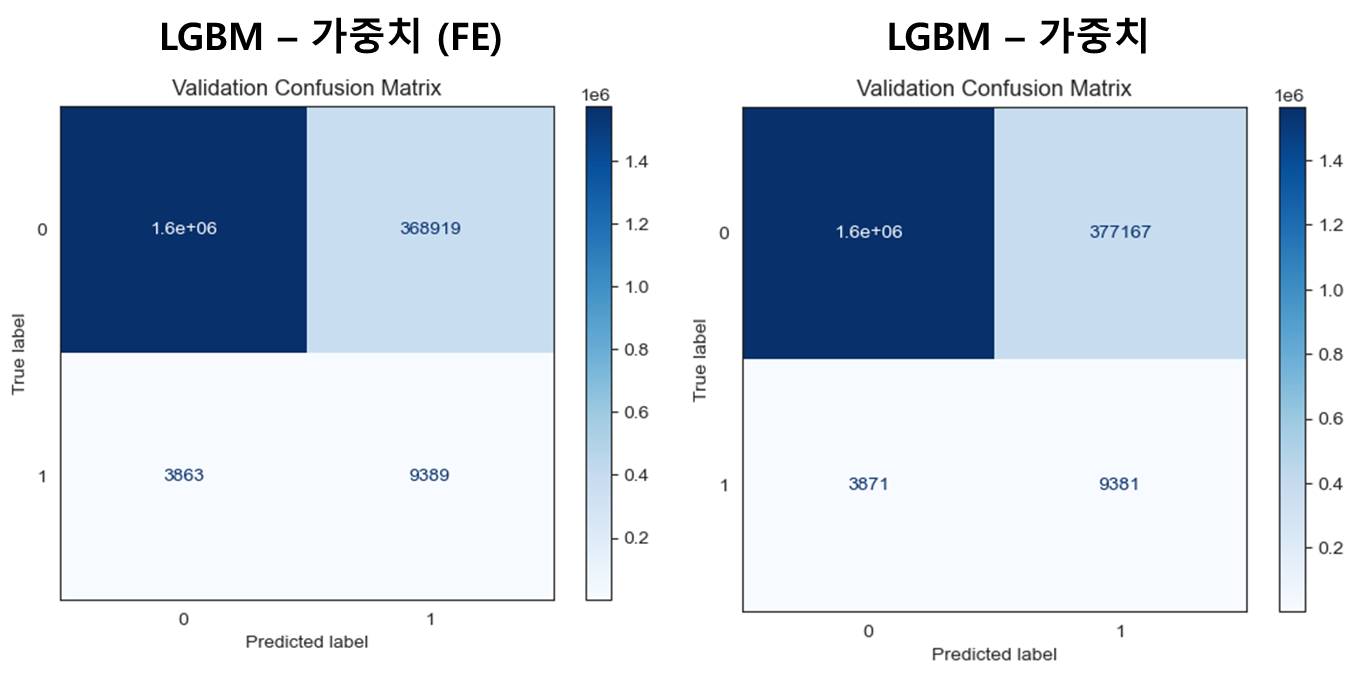

---

1차 선정된 컬럼들 + Feature Engineering을 통한 파생변수들로 모델링을 진행하였고, <br>
이 중에서도 또 영향력이 높은 컬럼들을 선정해서 2차 선정된 컬럼들로 모델링을 한 번 더 진행해보겠다.